# Machine Learning of Attrition at a particular company


Summary of Decisions Made:
 - Complete extensive EDA so decisions can be made for feature engineering.
 - Choose the 1 - f1-score and macro-average as an evaluation metric (which ensures per class quality assessments)
 - Generate Baseline prior to scaling,then one for scaled and skewed variables.
 - Prior to encoding and binning, deal with the outliers then regenerate a baseline model.
 - Create features by interaction and assess each interaction and it seffect on teh model
 - Binning of all continuous numerical variables according to clusters identified in the EDA, whilst still limiting the imbalance and bias I might introduce.
 - Frequency binning for discrete values from number of projects and time spent.
 - Attempt Weight of evidence binning to ranking the clusters if possible. This was not completed, but code is in the appendix.
 - Incorporate Recursive and Wrapper Methods to assess feature importance.
 - Assess methodology and suggest room for improvement.
 

## Initial check

### Import Libraries

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from dataset import Dataset as dataset
from typing import List
from skrebate import ReliefF

import ipywidgets as widgets
plt.style.use('seaborn-bright')
%matplotlib inline

### Loading the data

In [143]:
df = pd.read_csv('turnover.csv')

It is observed that can be seen that there are 14 999 records with 9 features, where the **left** column is the target variable. 

### Checking for missing data

In [6]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

The dataset has no missing values, so no techniques for dealing with missing values will applied during the feature engineering.

## Cleaning Column Names

It can be observed that the column names are not standardized, so they will be cleaned: *all lower case and more descriptive*

In [146]:
df = df.rename(columns={'number_project':'number_of_projects','average_montly_hours':'average_monthly_hours', 'sales': 'department', 'Work_accident':'work_accident','promotion_last_5years':'promotion_last_5_years'})
df.head(3)

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5_years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


*Below we rearrange the order of columns to ensure that the target variable is the last column of the dataframe.*

In [4]:
df = df[['satisfaction_level', 'last_evaluation', 'number_of_projects',
       'average_monthly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5_years', 'department', 'salary','left']]
df.head(3)

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spend_company,work_accident,promotion_last_5_years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1


#  Exploratory Data Analysis

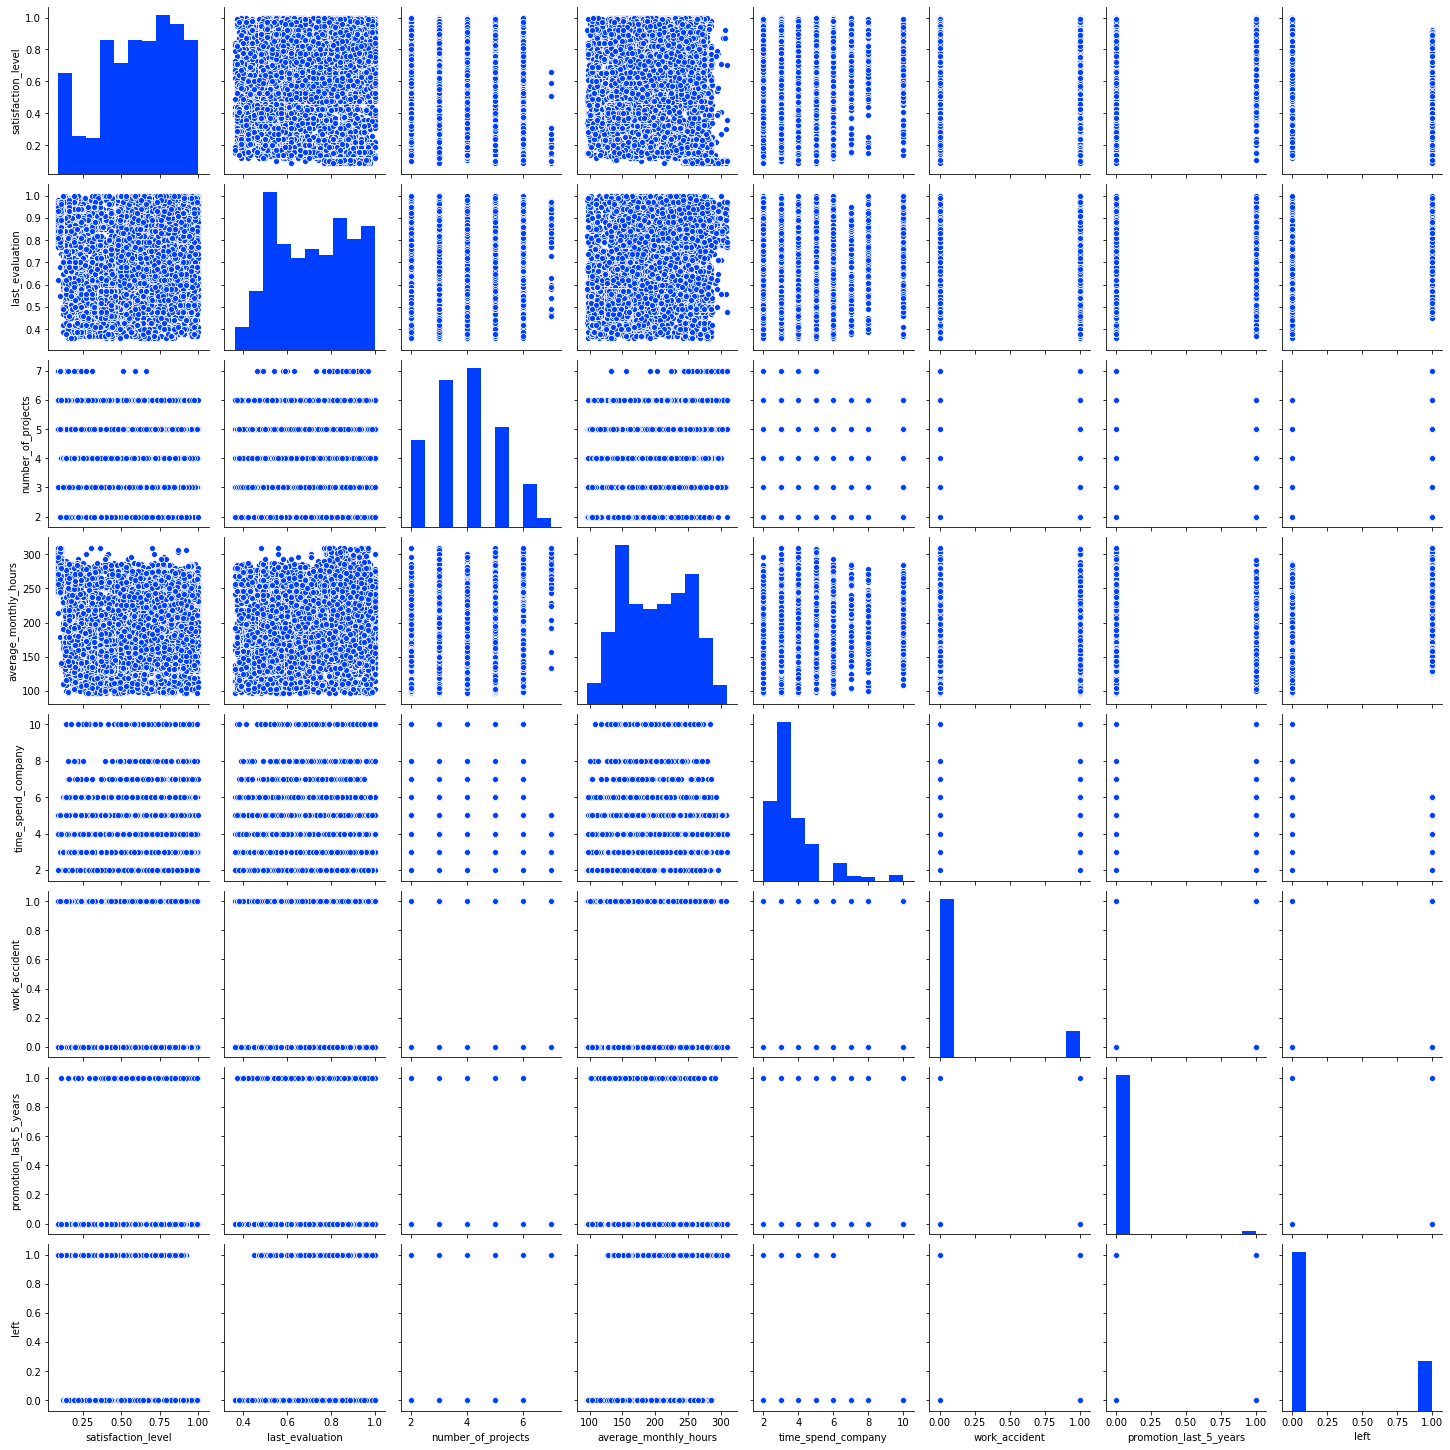

In [15]:
sns.pairplot(df)

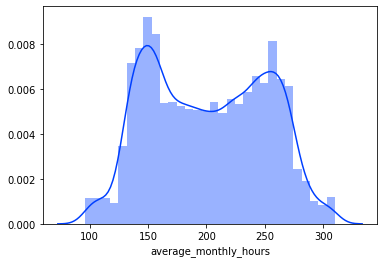

In [11]:
sns.distplot(df.average_monthly_hours, kde=True);

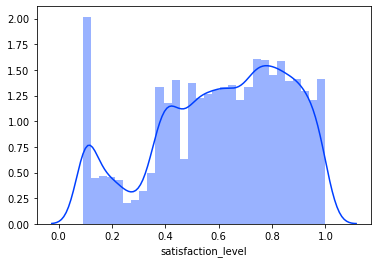

In [12]:
sns.distplot(df.satisfaction_level, kde=True);

In [ ]:
sns.distplot(df.satisfaction_level, kde=True);

In [363]:
#sns.boxplot(x='left',y='average_monthly_hours',data=df)

In [361]:
#df.groupby('left').average_monthly_hours.hist(alpha=0.6);

In [362]:
#sns.boxplot(x='left',y='number_of_projects',data=df)

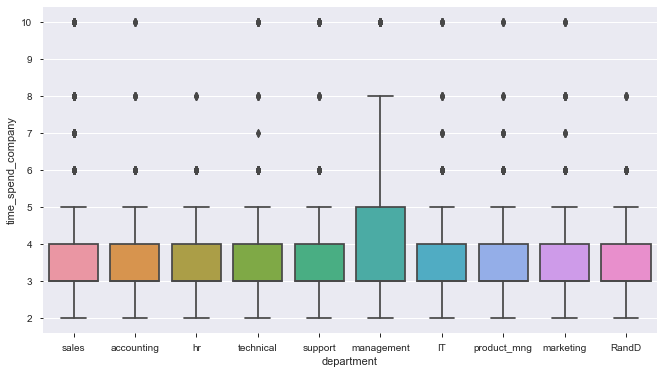

In [133]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='department',y='time_spend_company',data=df)

It is observed that in general, employees of each department the company have stayed at the company between 2-5 years where in management, it's between 2-6 years. The are only outliers greater than been at the company greater than the 5 or 6 years. But this is not enough to consider for removing the outliers.These will need to be considered with reference tot the target variable.

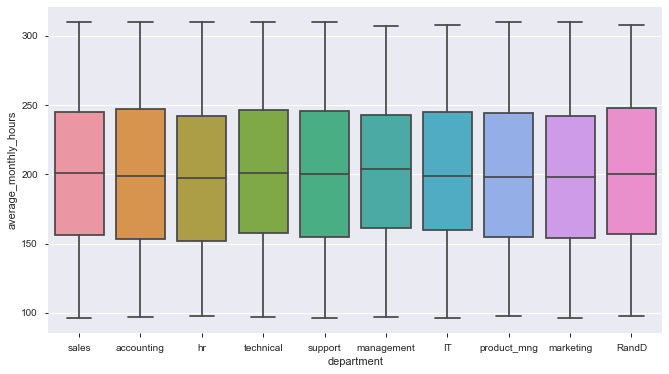

In [134]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(y='average_monthly_hours',x='department',data=df)

Employees from each department typically work the same hours and there are no outliers present according to the boxplot. To gain better insight, we'll need to assess this with regards to the target variable.

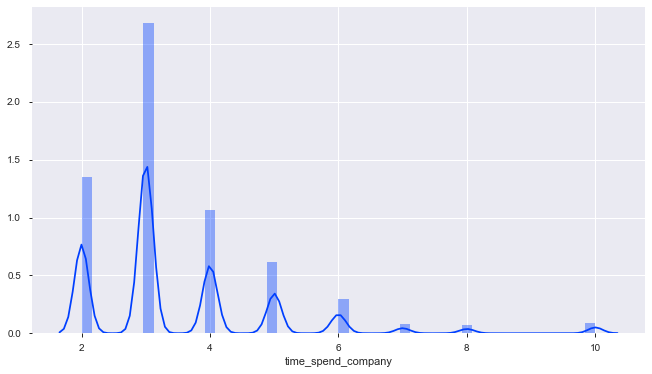

In [135]:
fig, ax = plt.subplots(figsize=(11,6))
sns.distplot(df.time_spend_company, kde=True)

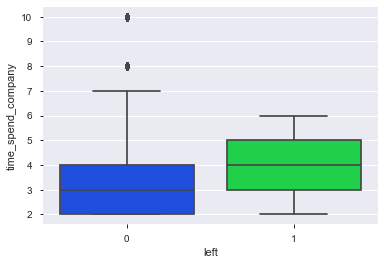

In [136]:
sns.boxplot(x='left',y='time_spend_company',data=df)

It is observed that that there are outliers of employees for those who stayed. This will be noted, but whether or not ti will  be considered will be investigated further later on.

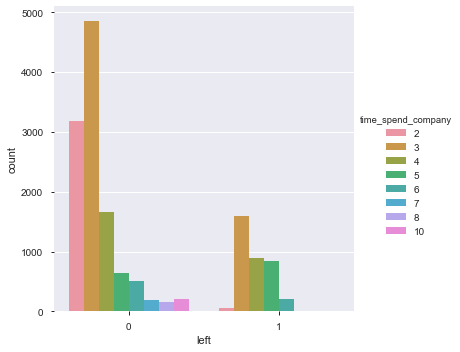

In [137]:
sns.catplot(x='left', hue='time_spend_company', kind='count', data=df);

We can observe that the 3rd year is a key year for the company, as the largest proportion either stay or decide to leave the company. 

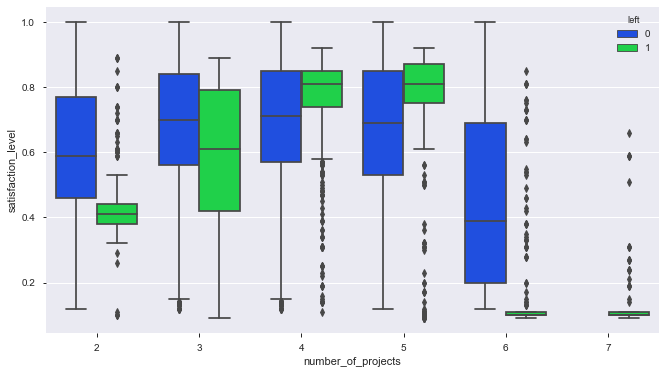

In [139]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='number_of_projects',y='satisfaction_level',hue='left',data=df)

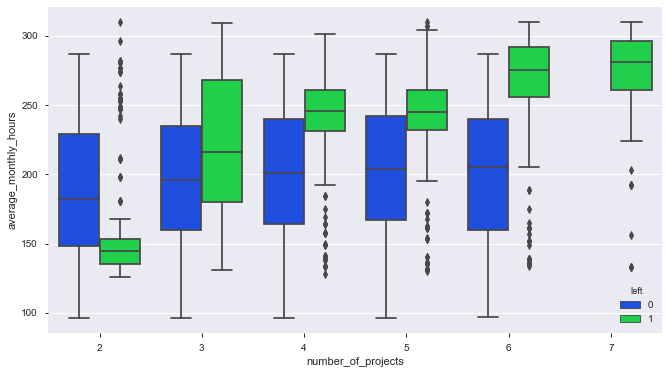

In [26]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='number_of_projects',y='average_monthly_hours',hue='left',data=df)

- It is observed that for people who have had 2 projects, the outliers for those who left generally have average monthly hours  greater than 175 hours.
- It is also noteworthy that those who have at least 4 projects, the outliers for those who left generally have average monthly hours less than 175 hours.

These observations are noted and may be taken into consideration for the feature engineering process.

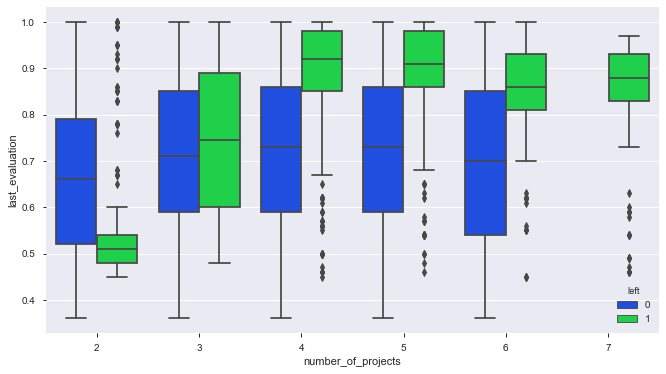

In [140]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='number_of_projects',y='last_evaluation',hue='left',data=df)

- It is observed that for people who completed 2 projects and who had a **last_evaluation** scores greater than 0.65, left the company.
- It is observed that for people who completed 4, 5, 6 & 7 projects and who had a **last_evaluation** scores less than 0.65, left the company.

These observations are noted and may be taken into consideration for the feature engineering process.

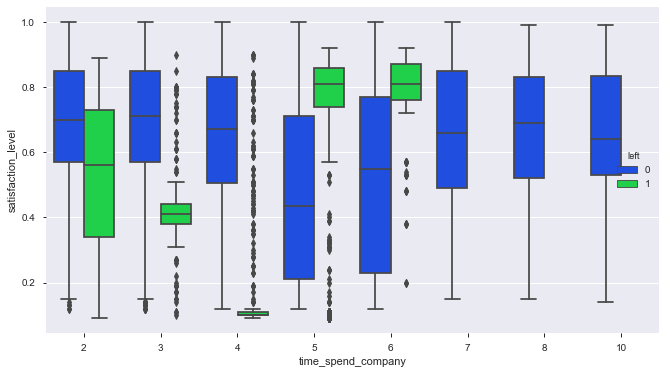

In [141]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='time_spend_company',y='satisfaction_level',hue='left',data=df)

- It is observed that for people who spend at least 3 years left, were regardless of the **satisfaction_level**.
- it is noteworthy that those spent at least 4 -5 years at the company, left regardless of the **satisfaction_level**.

These observations are noted and may be taken into consideration for the feature engineering process.

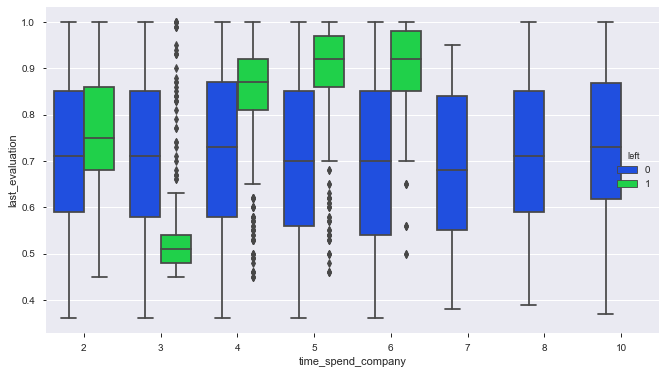

In [142]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='time_spend_company',y='last_evaluation',hue='left',data=df)

- It is observed that for people who spend at least 3 years, the outliers who left had a last evaluation greater than 0.65.
- It is observed that for people who spend at least 4,5,6 years, the outliers who left had a last evaluation was less than 0.7.

These observations are noted and may be taken into consideration for the feature engineering process.

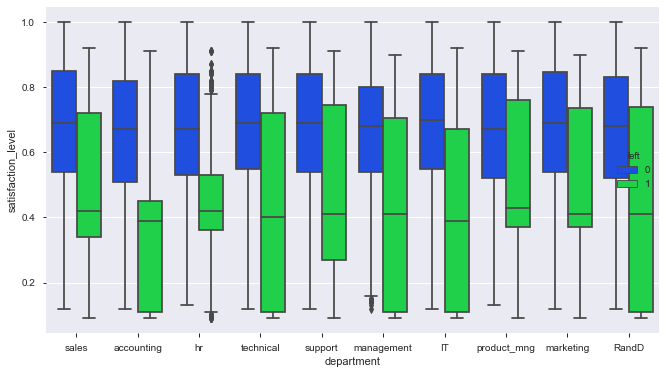

In [143]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='department',y='satisfaction_level',hue='left',data=df)

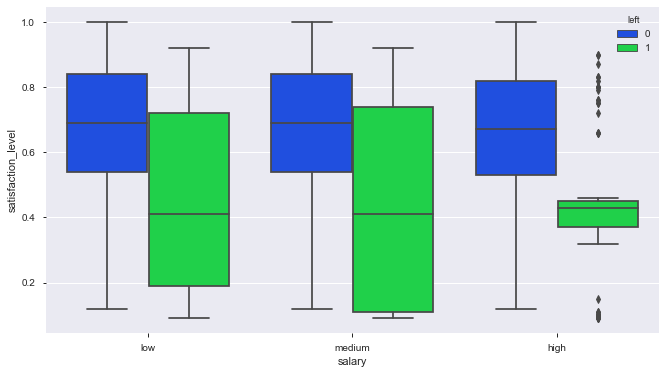

In [144]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='salary',y='satisfaction_level',hue='left',data=df)

There are outliers for people in the high salary region who left. Those who left with high satifaction level

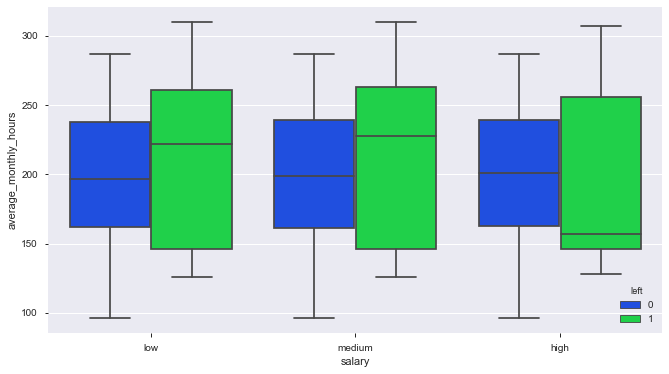

In [145]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='salary',y='average_monthly_hours',hue='left',data=df)

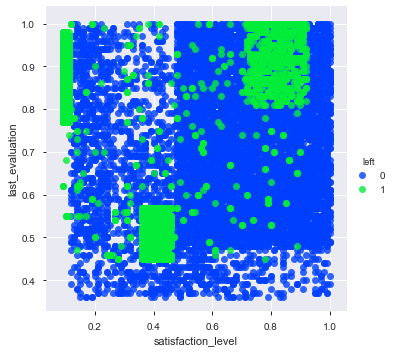

In [34]:
sns.lmplot(x='satisfaction_level', y='last_evaluation', data=df, fit_reg=False,hue='left')

- There is a strong relationship between those who's satisfaction level and last evaluation is between **(0.35 - 0.45)** and **(0.45 - 0.58)** respectively, for those who left the company. Moreover,
- There is a strong relationship between those who's satisfaction level and last evaluation is between **(0.05 - 0.1)** and **(0.75 - 0.95)** respectively, for those who left the company. Moreover,
- There is a strong relationship between those who's satisfaction level and last evaluation is between **(0.7 - 0.9)** and **(0.8 - 1)** respectively, for those who left the company. 

Having done some research about hr attrition, the [satisfaction level and last evaluation](http://otipo.com/site/user_resources/pulse_wp.pdf) are developed by extensive survey and the outputs are typically a percentage out of 100. This is noted, and may be used further in the analysis.

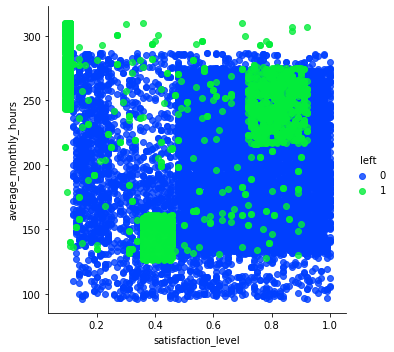

In [16]:
sns.lmplot(x='satisfaction_level', y='average_monthly_hours', data=df, fit_reg=False,hue='left')

- There is a strong relationship between those who's satisfaction level and average monthly hours is between **(0.35 - 0.48)** and **(125 - 160) hrs** respectively, for those who left the company. Moreover,
- There is a strong relationship between those who's satisfaction level and average monthly hours is between **(0.05 - 0.1)** and **(240 - 320) hrs** respectively, for those who left the company. Moreover,
- There is a strong relationship between those who's satisfaction level and average monthly hours is between **(0.7 - 0.9)** and **(210 - 275) hrs** respectively, for those left the company. 

Having initiated some further research about hr attrition, the [satisfaction level and average monthly hours](https://www.analyticsinhr.com/blog/job-satisfaction-engagement-surveys-measuring-wrong/) are related where if the average montlhy hours over a long time, will decrease the satisfaction. This is noted, and may be used further in the analysis.

## Data Transformation

### One hot encoding
Below, the previously renamed "sales" column is now encoded and the IT column is subsequently dropped to avoid the [dummy variable trap](https://www.algosome.com/articles/dummy-variable-trap-regression.html).

In [147]:
df = pd.concat([df, pd.get_dummies(df['department'],drop_first=False)], axis = 1)
df.head(3)

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5_years,department,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0


The **salary** category is ordinal. An ordinal encoder is applied whereby **low**: 0, **medium**: 1, **high**: 2.

In [148]:
df['salary'] = df['salary'].astype('category')
df['salary'] = df['salary'].cat.reorder_categories(['low','medium','high'])
df['salary'] = df['salary'].cat.codes
df.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5_years,department,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,sales,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,sales,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,sales,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,0,0,0,0,0,0,0,0,1,0,0


The department columns is now dropped because it will be redundant.

## Dealing with Skewness
To deal with the skewness, we must plot the skewness of all the numeric variables.

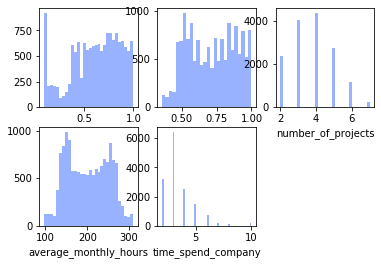

In [21]:
plt.subplot(231)
sns.distplot(df.satisfaction_level,hist=True,kde=False)
plt.subplot(232)
sns.distplot(df.last_evaluation,hist=True,kde=False)
plt.subplot(233)
sns.distplot(df.number_of_projects,hist=True,kde=False)
plt.subplot(234)
sns.distplot(df.average_monthly_hours,hist=True,kde=False)
plt.subplot(235)
sns.distplot(df.time_spend_company,hist=True,kde=False)

It can be seen that the skewness for the last evalution and average monthly hours feature is bi-modal, whilst skewness for the time spent at the company and the number of projects are left skewed. Transformations will be applied only if there is significant skewness and kurtosis. 

In [150]:
from scipy.special import boxcox1p
from scipy.stats import kurtosis, skew, boxcox_normmax
# satisfaction level
print('kurtosis for satisfaction level feature is: {}'.format(kurtosis(df['satisfaction_level'])))
print('skewness for satisfaction level feature is: {}'.format(skew(df['satisfaction_level'])))
print('')
# last evaluation
print('kurtosis for last evaluation feature is: {}'.format(kurtosis(df['last_evaluation'])))
print('skewness for last evaluation feature level is: {}'.format(skew(df['last_evaluation'])))
print('')
# number of projects
print('kurtosis for number of projects feature is: {}'.format(kurtosis(df['number_of_projects'])))
print('skewness for number of projects feature is: {}'.format(skew(df['number_of_projects'])))
print('')
# Average monthly hours
print('kurtosis for average monthly hours feature is: {}'.format(kurtosis(df['average_monthly_hours'])))
print('skewness for average monthly hours feature is: {}'.format(skew(df['average_monthly_hours'])))
print('')
# time spent at company in years
print('kurtosis for time spent at company feature is: {}'.format(kurtosis(df['time_spend_company'])))
print('skewness for time spent at company feature is: {}'.format(skew(df['time_spend_company'])))

kurtosis for satisfaction level feature is: -0.6710350084807528
skewness for satisfaction level feature is: -0.47631270075042725

kurtosis for last evaluation feature is: -1.2390272795182624
skewness for last evaluation feature level is: -0.0266190874373217

kurtosis for number of projects feature is: -0.49571279698843007
skewness for number of projects feature is: 0.3376718386088254

kurtosis for average monthly hours feature is: -1.1350032510931285
skewness for average monthly hours feature is: 0.05283670471826943

kurtosis for time spent at company feature is: 4.771219697202597
skewness for time spent at company feature is: 1.8531336980238529


It is observed that the only numerical feature with **skewness** > 0.75 and **kurtosis** > 3 is *time_spend_company*. Using a line of code from Jesus_renero features importance plots, we transform the skewness using box-cox. 

In [151]:
#from sklearn.preprocessing import PowerTransformer
#m1 = PowerTransformer(method='box-cox')
# print(m1.fit(df[['time_spend_company']]))
# m1.
df['time_spend_company'] = boxcox1p(df['time_spend_company'],boxcox_normmax(df['time_spend_company']+1))

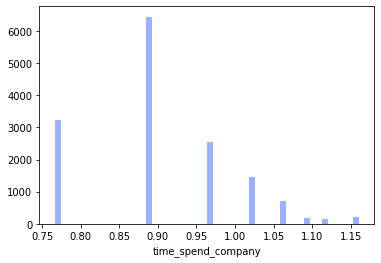

In [25]:
sns.distplot(df.time_spend_company,hist=True,kde=False)

In [153]:
df = df[['satisfaction_level', 'last_evaluation', 'number_of_projects',
       'average_monthly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5_years', 'salary','department','IT','RandD','accounting','hr','management','marketing','product_mng','sales','support','technical','left']]
df.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spend_company,work_accident,promotion_last_5_years,salary,department,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,left
0,0.38,0.53,2,157,0.886558,0,0,0,sales,0,0,0,0,0,0,0,1,0,0,1
1,0.80,0.86,5,262,1.061627,0,0,1,sales,0,0,0,0,0,0,0,1,0,0,1
2,0.11,0.88,7,272,0.964686,0,0,1,sales,0,0,0,0,0,0,0,1,0,0,1
3,0.72,0.87,5,223,1.020041,0,0,0,sales,0,0,0,0,0,0,0,1,0,0,1
4,0.37,0.52,2,159,0.886558,0,0,0,sales,0,0,0,0,0,0,0,1,0,0,1


In [154]:
HR_num_var = ['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company']


Now we will scale the data using the MinMaxScaler(). According to [scikit_learn documentation and lecture notes](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) on scaling, MinMaxScaler rescales the data set such that all feature values are in the range (0, 1)  but it is sensitive to outliers. Various outlier detection techniques will be applied after the baseline model creation. 



In [155]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
f1_trns = ColumnTransformer(transformers=
                                     [('scaler', MinMaxScaler(), HR_num_var)],
                                     remainder = 'passthrough',
                                     verbose =True)
f1_trns.get_params()

{'n_jobs': None,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('scaler',
   MinMaxScaler(copy=True, feature_range=(0, 1)),
   ['satisfaction_level',
    'last_evaluation',
    'number_of_projects',
    'average_monthly_hours',
    'time_spend_company'])],
 'verbose': True,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1)}

# Baseline without Scaling

In [156]:
X = df[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','IT','RandD','accounting','hr','management','marketing','product_mng','sales','support','technical']]
y = df['left']

## Train, Test Split

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
logitModel = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logitModel.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=True,
                   warm_start=False)

In [159]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
predictions = logitModel.predict(X_test)
train_predictions = logitModel.predict(X_train)
print('This is the confusion matrix for the training outcome:')
print(confusion_matrix(y_train,train_predictions))
print('')
print('This is the accuracy score for the training outcome:')
accuracy_score(y_train,train_predictions)

This is the confusion matrix for the training outcome:
[[8493  641]
 [1723 1142]]

This is the accuracy score for the training outcome:


0.8029835819651637

In [160]:
print('This is the classfication report with the f1 score:')
print('')
print(classification_report(y_test,predictions))

This is the classfication report with the f1 score:

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2294
           1       0.62      0.38      0.47       706

    accuracy                           0.80      3000
   macro avg       0.73      0.66      0.68      3000
weighted avg       0.78      0.80      0.78      3000



In [36]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
for folds in range(5,11):
    
    kf = StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)
    
    print('------------------------------------\n')
    print('K:', folds)
    model = LogisticRegression()
    
    # Perform cross-validation
    scores_1 = cross_val_score(model, X, y, cv=kf,scoring='f1')
    predict1 = cross_val_predict(model,X,y)
    print("Cross-validated scores:", scores_1)
    print("Mean CV f1_score:", np.mean(scores_1))
    print('Std CV f1_score:', np.std(scores_1))
    print(classification_report(y,predict1))

------------------------------------

K: 5
Cross-validated scores: [0.54170107 0.4418395  0.52487136 0.54857143 0.54785479]
Mean CV f1_score: 0.5209676275287138
Std CV f1_score: 0.04047533895071715
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     11428
           1       0.62      0.45      0.52      3571

    accuracy                           0.80     14999
   macro avg       0.73      0.68      0.70     14999
weighted avg       0.79      0.80      0.79     14999

------------------------------------

K: 6
Cross-validated scores: [0.54671968 0.52803262 0.5562249  0.54615385 0.51639344 0.57278782]
Mean CV f1_score: 0.5443853851970365
Std CV f1_score: 0.01828665564950606
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     11428
           1       0.62      0.45      0.52      3571

    accuracy                           0.80     14999
   macro avg       0.73      0.68      0.70     

To evaluate our 1st baseline model we use code from [Jesus_Renero_Github](https://github.com/renero/class_notebooks/blob/master/Logistic%20regression.ipynb) to plot the ROC with the thresholds. Analyzing the code, it has been adapted from the sci-kit learn library and is a good base to generate the ROC. Moreover, after every change within the model, cross-validation is run to assess the stability of the parameters for the model.

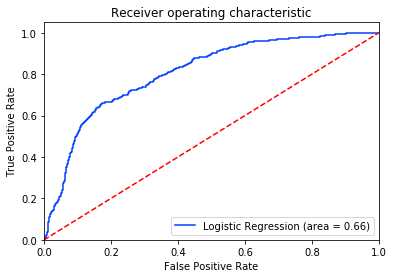

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, logitModel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [161]:
f1_trns.fit(X_train)

[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scaler',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['satisfaction_level', 'last_evaluation',
                                  'number_of_projects', 'average_monthly_hours',
                                  'time_spend_company'])],
                  verbose=True)

In [162]:
X_train_trns = f1_trns.transform(X_train)
X_test_trns = f1_trns.transform(X_test)

In [163]:
f1_new = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = 'None',
                          verbose = True)
f1_new.fit(X_train_trns,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight='None', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=True,
                   warm_start=False)

In [164]:
new_predictions = f1_new.predict(X_test_trns)
train_new_predictions = f1_new.predict(X_train_trns)
print(classification_report(y_test,new_predictions))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2294
           1       0.57      0.38      0.46       706

    accuracy                           0.79      3000
   macro avg       0.70      0.65      0.66      3000
weighted avg       0.77      0.79      0.77      3000



In [44]:
for folds in range(5,11):
    
    kf = StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)
    
    print('------------------------------------\n')
    print('K:', folds)
    model = LogisticRegression()
    
    # Perform cross-validation
    scores_1 = cross_val_score(model, X_train_trns, y_train, cv=kf,scoring='f1')
    predict1 = cross_val_predict(model,X,y)
    print("Cross-validated scores:", scores_1)
    print("Mean CV f1_score:", np.mean(scores_1))
    print('Std CV f1_score:', np.std(scores_1))
    print(classification_report(y,predict1))

------------------------------------

K: 5
Cross-validated scores: [0.44492441 0.47516199 0.47758081 0.47169811 0.47854077]
Mean CV f1_score: 0.4695812184351051
Std CV f1_score: 0.012552702873915819
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     11428
           1       0.62      0.45      0.52      3571

    accuracy                           0.80     14999
   macro avg       0.73      0.68      0.70     14999
weighted avg       0.79      0.80      0.79     14999

------------------------------------

K: 6
Cross-validated scores: [0.44559585 0.45897436 0.47680412 0.46941323 0.50629723 0.46469833]
Mean CV f1_score: 0.47029718857985636
Std CV f1_score: 0.01874759569589228
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     11428
           1       0.62      0.45      0.52      3571

    accuracy                           0.80     14999
   macro avg       0.73      0.68      0.70   

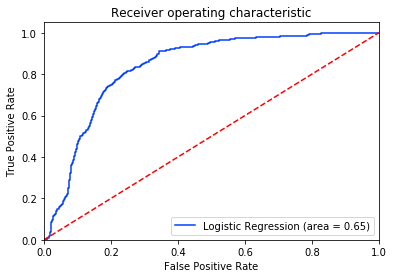

In [165]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, new_predictions)
fpr, tpr, thresholds = roc_curve(y_test, f1_new.predict_proba(X_test_trns)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

The results from the MinMaxScaler slightly decreased the f1 score after fixing the skewness. A beteter transformer might have been the log1p transformer, but the MinMaxScaler is sufficient. But these results are poor, feature engineering is required to imporve from the baseline.

## Feature Creation
To create new features, we will use domain knowledge of Human Resources. The following new features will created through interactions described below.

### New features
During EDA, several key findings were made with regards to the satisfaction level. The following features will be created to improve the score of model:

- $\frac{satisfactionLevel}{numberOfProjects}$                  
- $\frac{lastEvaluation}{numberOfProjects}$                     

- $\frac{satisfactionLevel}{lastEvaluation}$                    

- $\frac{satisfactionLevel*lastEvaluation}{averageMonthlyHours}$ 

- $\ (Time spent at company)^{2}$ 

- $\ (Time spent at the company)^{2})*(Satisfaction level))$  

- $\mathbf{satisfaction level} \times \mathbf{last evaluation}$ 
- $\mathbf{satisfaction level} \times \mathbf{num of projects}$
- $\mathbf{last eval} \times \mathbf{num of projects}$
- $\mathbf{no of projects} \times \mathbf{average monthly hours}$
- $\mathbf{last eval} \times \mathbf{no of projects}$
- $\frac{(average monthly hours)(time spend company)}{no of projects}$

In [345]:
df['sat_per_proj'] = df['satisfaction_level']/df['number_of_projects']
df['eval_per_proj'] = df['last_evaluation']/df['number_of_projects']
df['sat_per_eval'] = df['satisfaction_level']/df['last_evaluation']
df['sat_eval_monthly'] = ((df['satisfaction_level']*df['last_evaluation'])/(df['average_monthly_hours']))
df['time_spend_company_sq'] = (df['time_spend_company']*df['time_spend_company'])
df['Satisfaction_tenure'] = (df['time_spend_company']*df['time_spend_company'])*df['satisfaction_level']
df['sat_mlt_eval'] = df['satisfaction_level']*df['last_evaluation']
df['sat_mlt_proj'] = df['satisfaction_level']*df['number_of_projects']
df['eval_mlt_proj'] = df['last_evaluation']*df['number_of_projects']
df['pro_mlt_hrs'] = df['number_of_projects']*df['average_monthly_hours']
df['workload'] = (df['time_spend_company']*df['average_monthly_hours'])/df['number_of_projects']



### Satisfaction per No. of Projects

In [52]:
X1 = df[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','RandD','IT','hr','management','marketing','product_mng','sales','support','technical','sat_per_proj']]
y1 = df['left']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [53]:
logit1Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = 1)
logit1Model.fit(X1_train,y1_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [56]:
log1s = logit1Model.predict(X1_test)
train1 = logit1Model.predict(X1_train)
print(classification_report(y1_test,log1s))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2294
           1       0.66      0.45      0.54       706

    accuracy                           0.82      3000
   macro avg       0.75      0.69      0.71      3000
weighted avg       0.80      0.82      0.80      3000



By cross validating and introducing the new parameter, the f-score was introducing was increased by 0.05. Care will be taken, to minimize overfitting.

### Last Evaluation per Number of Projects

In [170]:
X2 = df[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','RandD','accounting','hr','management','marketing','product_mng','sales','support','technical','eval_per_proj','sat_per_proj']]
y2 = df['left']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

logit2Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = 1)
logit2Model.fit(X2_train,y2_train)
log2s = logit2Model.predict(X2_test)
train2 = logit2Model.predict(X2_train)
print(classification_report(y2_test,log2s))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       0.85      0.92      0.89      2294
           1       0.66      0.47      0.55       706

    accuracy                           0.82      3000
   macro avg       0.75      0.70      0.72      3000
weighted avg       0.80      0.82      0.81      3000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


After cross-validation, there is not much, if any increase in the f-score. Care will be taken in determining the correct parameters to introduce.

### Satisfaction Level/Last Evaluation

In [71]:
X3 = df[['last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','RandD','IT','accounting','hr','management','marketing','product_mng','sales','support','technical','sat_per_eval']]
y3 = df['left']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

logit3Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logit3Model.fit(X3_train,y3_train)
log3s = logit3Model.predict(X3_test)
train3 = logit3Model.predict(X3_train)
print(classification_report(y3_test,log3s))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2294
           1       0.61      0.43      0.50       706

    accuracy                           0.80      3000
   macro avg       0.72      0.67      0.69      3000
weighted avg       0.78      0.80      0.79      3000



After the introduction of this parameter, there is a significant decrease in the f-score going closer to the baseline.

### Satisfaction per Average Monthly Hours

In [73]:
X4 = df[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','RandD','accounting','hr','management','marketing','product_mng','sales','support','technical','sat_eval_monthly','sat_per_proj']]
y4 = df['left']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

logit4Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = 'None',
                          verbose = True)
logit4Model.fit(X4_train,y4_train)
log4s = logit4Model.predict(X4_test)
train4 = logit4Model.predict(X4_train)
print(classification_report(y4_test,log4s))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       0.85      0.93      0.88      2294
           1       0.65      0.45      0.53       706

    accuracy                           0.81      3000
   macro avg       0.75      0.69      0.71      3000
weighted avg       0.80      0.81      0.80      3000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


The f1-score and weighted average f1 score remain stable.

### Time at company Sq.

In [94]:
X5 = df[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','RandD','accounting','hr','management','marketing','product_mng','sales','support','technical','time_spend_company_sq','eval_per_proj']]
y5 = df['left']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

logit5Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = 'None',
                          verbose = True)
logit5Model.fit(X5_train,y5_train)
log5s = logit5Model.predict(X5_test)
train5 = logit5Model.predict(X5_train)
print(classification_report(y5_test,log5s))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2294
           1       0.61      0.43      0.50       706

    accuracy                           0.80      3000
   macro avg       0.72      0.67      0.69      3000
weighted avg       0.78      0.80      0.79      3000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


The f1-score and weighted average f1 score slightly decreased from the previous introduction of parameters. These features will be better analyzed in the feature selection process.

### Satisfaction for Tenure

In [171]:
X6 = df[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','RandD','accounting','hr','management','marketing','product_mng','sales','support','technical','eval_per_proj','Satisfaction_tenure']]
y6 = df['left']
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2, random_state=42)

logit6Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = 'None',
                          verbose = True)
logit6Model.fit(X6_train,y6_train)
log6s = logit6Model.predict(X6_test)
train6 = logit6Model.predict(X6_train)
print(classification_report(y6_test,log6s))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2294
           1       0.59      0.39      0.47       706

    accuracy                           0.79      3000
   macro avg       0.71      0.65      0.67      3000
weighted avg       0.77      0.79      0.78      3000



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


After completing the iterations of adding the new feature, the correlation coefficients with regards to target variable.

In [172]:
cor_target = abs(cor["left"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

satisfaction_level       0.398114
time_spend_company       0.246776
sat_per_proj             0.218698
eval_mlt_proj            0.110375
sat_mlt_eval             0.301514
sat_per_eval             0.359117
sat_eval_monthly         0.328404
time_spend_company_sq    0.232018
Satisfaction_tenure      0.225123
workload                 0.180659
left                     1.000000
Name: left, dtype: float64

## Outlier Detection: Prior to Binning
The implementation of the local outlier factor has been adapted from the [advanced housing regression github of renero](https://render.githubusercontent.com/view/ipynb?commit=3dee2af0df51a2615602d4c9572e109e54d8e494&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f72656e65726f2f636c6173735f6e6f7465626f6f6b732f336465653261663064663531613236313536303264346339353732653130396535346438653439342f464531253230486f6d656d616465253230706970656c696e65732e6970796e62&nwo=renero%2Fclass_). Various arguments within function including the reset_index have been altered to ensure the new dataframe correctly indexed.

In [174]:
from sklearn.neighbors import LocalOutlierFactor
n_neighbors = 25
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto')
y_pred_1 = lof.fit_predict(df[HR_num_var])
outliers = np.where(y_pred_1 == -1)
df_new = df.drop(df.index[outliers])
df_new.reset_index(inplace = True, drop = True)

In [282]:
mms = MinMaxScaler()
df_new[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','eval_per_proj','sat_per_eval','sat_eval_monthly','time_spend_company_sq','Satisfaction_tenure','sat_mlt_eval','sat_mlt_proj','eval_mlt_proj','pro_mlt_hrs','workload']] = mms.fit_transform(df_new[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','eval_per_proj','sat_per_eval','sat_eval_monthly','time_spend_company_sq','Satisfaction_tenure','sat_mlt_eval','sat_mlt_proj','eval_mlt_proj','pro_mlt_hrs','workload']])

### Baseline after Outlier Removal

In [285]:
Xb = df_new[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','work_accident',
       'promotion_last_5_years','salary','IT','RandD','accounting','hr','management','marketing','product_mng','sales','support','technical']]
yb = df_new['left']

X_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb, yb, test_size=0.2, random_state=42)
logitModelb = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logitModelb.fit(X_trainb,y_trainb)
predictionsb = logitModelb.predict(X_testb)
btrain_predictions = logitModel.predict(X_trainb)
print(classification_report(y_testb,predictionsb))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2138
           1       0.65      0.50      0.57       707

    accuracy                           0.81      2845
   macro avg       0.75      0.71      0.72      2845
weighted avg       0.80      0.81      0.80      2845



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


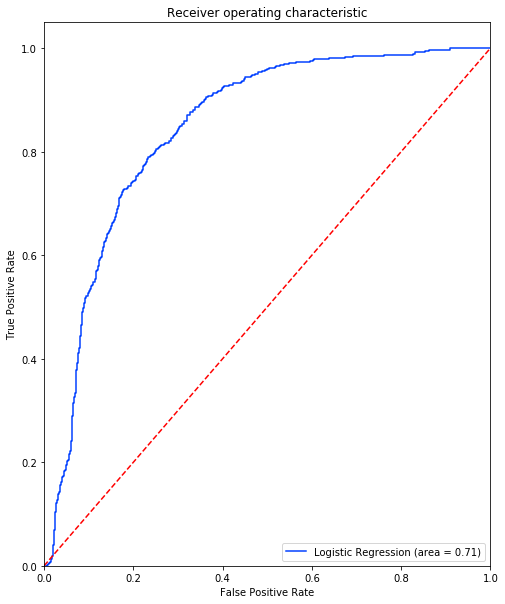

In [336]:
logit_roc_auc = roc_auc_score(y_testb, predictionsb)
fpr, tpr, thresholds = roc_curve(y_testb, logitModelb.predict_proba(X_testb)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

After removing outliers, the baseline f1-score increased by 0.1 and the macro average by 0.04. Moreover, the ROC curve show a more stable model.

### Binning

There are various methods and techniques for binning. Approaches and methods for binning are inspired by work completed [Chris Moffit](https://pbpython.com/pandas-qcut-cut.html).

There are numerous reasons to bin, but specifically for this data as is presented in the EDA, for features satisfaction level and last evaluation: Binning methods smooth the sorted data value by consulting its “neighborhood”, that is, the values around it according to [ML Binning or Discretization]

According to a post by [Baijayanta Roy](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02) there are several methods for encoding both discrete and continous variables. 

Because we are using a logit regression there were several techniques implemented for binning: 

- Adaptive binning - the scale of the bin has different widths according to the histogram scales and the clusters identified in the EDA. The size of the bins are designed to ensure no bias is introduced into the sample.

- Weighted of Evidence (WoE) Encoding, which is a measure of the strength of a grouping technique to separajayantate good and bad. i.e how much the evidence supports or undermines the hypothesis. Code is inspired from [Baijayanta Roy](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02). WoE can lead to overfitting, so should only be done on the train dataset.


#### Continuous Variables Binning: Satisfaction Level

In [346]:
sl_labels_3 = ['sat_1','sat_2','sat_3','sat_4','sat_5']
sl_bins = [-.0000009, 0.15, 0.3, 0.5, 0.65,1]
df_new['sat_level'] = pd.cut(df_new['satisfaction_level'], bins=sl_bins, labels=sl_labels_3)

In [347]:
df_new1 = pd.concat([df_new, pd.get_dummies(df_new['sat_level'])], axis = 1)

In [235]:
Xn1 = df_new1[['last_evaluation','number_of_projects','average_monthly_hours','work_accident',
       'promotion_last_5_years','salary','hr','IT','accounting','management','sales','support','technical','sat_1','sat_2','sat_3','sat_4','sat_5']]
yn1 = df_new1['left']
Xn1_train, Xn1_test, yn1_train, yn1_test = train_test_split(Xn1, yn1, test_size=0.2, random_state=42)

logitn1Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logitn1Model.fit(Xn1_train,yn1_train)
logn1s = logitn1Model.predict(Xn1_test)
train1 = logitn1Model.predict(Xn1_train)
print(classification_report(yn1_test,logn1s))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2138
           1       0.73      0.58      0.65       707

    accuracy                           0.84      2845
   macro avg       0.80      0.75      0.77      2845
weighted avg       0.83      0.84      0.84      2845



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


After binning and training the model cross validation f1-score increased by 0.08 and marco average by 0.05.

#### Continuous Variables Binning: Last Evaluation

In [348]:
LE_labels_3 = ['eval_1','eval_2', 'eval_3','eval_4','eval_5','eval_6','eval_7']
le_bins = [-.00009, 0.18, 0.32, 0.38,0.58,0.7,0.9,1]
df_new1['eval_level'] = pd.cut(df_new1['last_evaluation'], bins=le_bins, labels=LE_labels_3)

In [237]:
df_new2 = pd.concat([df_new1, pd.get_dummies(df_new1['eval_level'])], axis = 1)
df_new2.head(3)

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spend_company,work_accident,promotion_last_5_years,salary,department,IT,...,sat_4,sat_5,eval_level,eval_1,eval_2,eval_3,eval_4,eval_5,eval_6,eval_7
0,0.318681,0.265625,0.0,0.285047,0.305549,0,0,0,sales,0,...,0,0,eval_2,0,1,0,0,0,0,0
1,0.780220,0.781250,0.6,0.775701,0.749228,0,0,1,sales,0,...,0,1,eval_6,0,0,0,0,0,1,0
2,0.021978,0.812500,1.0,0.822430,0.503549,0,0,1,sales,0,...,0,0,eval_6,0,0,0,0,0,1,0


In [331]:
Xn2 = df_new2[['number_of_projects','average_monthly_hours','work_accident',
       'promotion_last_5_years','salary','hr','management','IT','accounting','product_mng','sales','support','technical','sat_1','sat_2','sat_3','sat_4','sat_5','eval_1','eval_2','eval_3','eval_4','eval_5','eval_6','eval_7']]
yn2 = df_new2['left']
Xn2_train, Xn2_test, yn2_train, yn2_test = train_test_split(Xn2, yn2, test_size=0.2, random_state=42)

logitn2Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logitn2Model.fit(Xn2_train,yn2_train)
logn2s = logitn2Model.predict(Xn2_test)
trainn2 = logitn2Model.predict(Xn2_train)
print(classification_report(yn2_test,logn2s))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2138
           1       0.72      0.63      0.67       707

    accuracy                           0.85      2845
   macro avg       0.80      0.77      0.79      2845
weighted avg       0.84      0.85      0.84      2845



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


This increased the f1-score by 0.02 points and the macro average by 0.02.

#### Continuous Variables Binning: Average Monthly Hours

In [352]:
AMH_labels_3 = ['low_amh','me','mh_AMH','hh_AMH']
AMH_bins = [-.00009, 0.25,0.35,0.6, 1]
df_new2['avg_hours'] = pd.cut(df_new2['average_monthly_hours'], bins=AMH_bins, labels=AMH_labels_3)

In [351]:
df_new3 = pd.concat([df_new2, pd.get_dummies(df_new2['avg_hours'])], axis = 1)

In [247]:
Xn3 = df_new3[['number_of_projects','work_accident',
       'promotion_last_5_years','salary','hr','management','IT','accounting','product_mng','sales','support','technical','Satisfaction_tenure','time_spend_company','sat_1','sat_2','sat_3','sat_4','sat_5','eval_1','eval_2','eval_3','eval_4','eval_5','eval_6','eval_7','low_amh','me','mh_AMH','hh_AMH','sat_per_eval']]
yn3 = df_new3['left']
Xn3_train, Xn3_test, yn3_train, yn3_test = train_test_split(Xn3, yn3, test_size=0.2, random_state=42)

logitn3Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logitn3Model.fit(Xn3_train,yn3_train)
logn3s = logitn3Model.predict(Xn3_test)
trainn3 = logitn3Model.predict(Xn3_train)
print(classification_report(yn3_test,logn3s))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2138
           1       0.78      0.81      0.79       707

    accuracy                           0.89      2845
   macro avg       0.86      0.87      0.86      2845
weighted avg       0.90      0.89      0.90      2845



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [255]:
df_new3['time_spend_company'].value_counts()

0.4    4322
0.2    3955
0.6    2668
0.0    1898
0.8    1136
1.0     244
Name: number_of_projects, dtype: int64

#### Discrete Binning: Number of Projects

In [256]:
#Number of projects
nop_labels_3 = [0, 0.5, 1]
nop_bins = [-.000009,0.2,0.4, 1]
df_new3['num_proj'] = pd.cut(df_new3['number_of_projects'], bins=nop_bins, labels=nop_labels_3)

df_new3.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spend_company,work_accident,promotion_last_5_years,salary,department,IT,...,eval_4,eval_5,eval_6,eval_7,avg_hours,low_amh,me,mh_AMH,hh_AMH,num_proj
0,0.318681,0.265625,0.0,0.285047,0.305549,0,0,0,sales,0,...,0,0,0,0,me,0,1,0,0,0.0
1,0.780220,0.781250,0.6,0.775701,0.749228,0,0,1,sales,0,...,0,0,1,0,hh_AMH,0,0,0,1,1.0
2,0.021978,0.812500,1.0,0.822430,0.503549,0,0,1,sales,0,...,0,0,1,0,hh_AMH,0,0,0,1,1.0
3,0.692308,0.796875,0.6,0.593458,0.643837,0,0,0,sales,0,...,0,0,1,0,mh_AMH,0,0,1,0,1.0
4,0.307692,0.250000,0.0,0.294393,0.305549,0,0,0,sales,0,...,0,0,0,0,me,0,1,0,0,0.0


In [293]:
Xn4 = df_new3[['num_proj','work_accident',
       'promotion_last_5_years','salary','hr','management','IT','accounting','product_mng','sales','support','technical','Satisfaction_tenure','sat_1','sat_2','sat_3','sat_4','sat_5','eval_1','eval_2','eval_3','eval_4','eval_5','eval_6','eval_7','low_amh','me','mh_AMH','hh_AMH','sat_per_eval','workload']]
yn4 = df_new3['left']
Xn4_train, Xn4_test, yn4_train, yn4_test = train_test_split(Xn4, yn4, test_size=0.2, random_state=42)

logitn4Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logitn4Model.fit(Xn4_train,yn4_train)
logn4s = logitn4Model.predict(Xn4_test)
trainn4 = logitn4Model.predict(Xn4_train)
print(classification_report(yn4_test,logn4s))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2138
           1       0.79      0.82      0.81       707

    accuracy                           0.90      2845
   macro avg       0.87      0.88      0.87      2845
weighted avg       0.90      0.90      0.90      2845



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


#### Discrete Binning: Time Spent at Company
For time spent, we will utilized frequency encoding. It helps the model to understand and assign the weight in direct and inverse proportion.

In [268]:
#Time spent company
ts = df_new3.groupby('time_spend_company').size()/len(df_new3)
df_new3.loc[:,'time_spent_prop'] = df_new3['time_spend_company'].map(ts)


In [297]:
Xn5 = df_new3[['num_proj','work_accident','time_spent_prop',
       'promotion_last_5_years','salary','hr','management','IT','accounting','product_mng','sales','support','technical','Satisfaction_tenure','sat_1','sat_2','sat_3','sat_4','sat_5','eval_1','eval_2','eval_3','eval_4','eval_5','eval_6','eval_7','low_amh','me','mh_AMH','hh_AMH','sat_per_eval']]
yn5 = df_new3['left']
Xn5_train, Xn5_test, yn5_train, yn5_test = train_test_split(Xn5, yn5, test_size=0.2, random_state=42)

logitn5Model = LogisticRegression(penalty = 'none',
                          solver = 'lbfgs',
                          class_weight = None,
                          verbose = True)
logitn5Model.fit(Xn5_train,yn5_train)
logn5s = logitn5Model.predict(Xn5_test)
trainn5 = logitn5Model.predict(Xn5_train)
print(classification_report(yn5_test,logn5s))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2138
           1       0.80      0.82      0.81       707

    accuracy                           0.90      2845
   macro avg       0.87      0.88      0.87      2845
weighted avg       0.91      0.90      0.91      2845



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


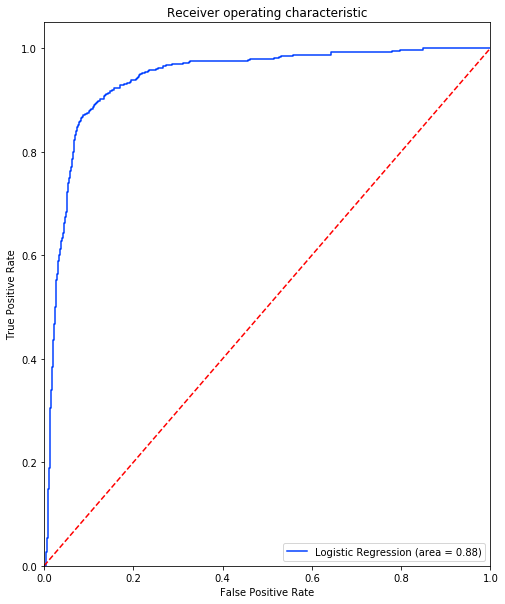

In [340]:
logit_roc_auc = roc_auc_score(yn5_test, logn5s)
fpr, tpr, thresholds = roc_curve(yn5_test, logitn5Model.predict_proba(Xn5_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [ ]:
From the baseline, the area of the 

## Feature Selection

### Correlation Co-efficient

In [349]:
plt.figure(figsize=(12,10))
cor = df_1[['satisfaction_level','last_evaluation','number_of_projects','average_monthly_hours','time_spend_company','sat_per_proj','eval_mlt_proj','sat_mlt_eval','eval_per_proj','sat_per_eval','sat_eval_monthly','time_spend_company_sq','Satisfaction_tenure','workload','left']].corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

<Figure size 864x720 with 0 Axes>

There is significant multi-collinearity between the newly created variables. Removal of the interactions is necessary. Not many features have a high correlation with the target variable but the highest correlation is time spent at the company, the wnewly created workload variable, eval_projects and average monthly hours.

### Univariate Feature Selection

Credit for partial implementation of this code is given [Machine Learning Mastery.com:](https://machinelearningmastery.com/feature-selection-machine-learning-python/)

In [350]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# load data
X_1 = Xn5
Y_1 = yn5
# feature extraction
test1 = SelectKBest(score_func=f_classif, k=4)
fit_1 = test1.fit(X_1, Y_1)
# summarize scores
set_printoptions(precision=3)
print(fit_1.scores_)
features1 = fit_1.transform(X_1)
# summarize selected features
#print(features1[0:15,:])

[2.677e+02 3.434e+02 2.883e+01 5.453e+01 3.590e+02 1.104e+01 2.859e+01
 2.186e+00 3.697e+00 8.673e-01 2.457e+00 1.287e+00 3.854e+00 7.592e+02
 1.286e+03 4.683e+00 1.199e+03 9.388e+02 6.522e+02 1.066e+02 3.856e+02
 6.530e+01 9.249e+02 1.539e+02 8.740e+01 9.772e+01 3.169e+02 1.597e+00
 1.367e+03 3.155e+02 2.106e+03]


### Recursive Feature Selection

We are applying Recursive Feature Selection because it recursively removes attributes and builds a model on those attributes that remain improving classification performance.

In [302]:
from sklearn.feature_selection import RFE, RFECV
mdl = LogisticRegression()
rfe = RFECV(estimator=mdl,step=1,cv=10,scoring='f1')
rfe1 = rfe.fit(Xn5, yn5)

print(rfe1.n_features_)
print(rfe1.support_)
print(rfe1.ranking_)

print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_))))
#print('Selected features: {}'.format(list(rfe1[:, rfe.support_])))

30
[ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (2,)]


Ranking and sorting the features as above, does not give adequate insight into the ranking of the features. So we generate a graph.

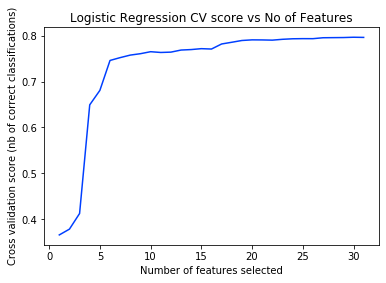

In [303]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

### Recursive Elimination: Tuning
From the graph it is not abundantly clear what is the optimum number of features that are selected. To optimise this based on the  macro average score, code is reworked to find the number of features [Recursive Elimination Optimisation Inspiration](https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-02-11262b7f7a5c).

In [304]:

nof_list=np.arange(1,20)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(Xn5,yn5, test_size = 0.2, random_state = 42)
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 18
Score with 18 features: 0.893849


Having selected the 18 features, we now list the features to use in the final model.

In [306]:

cols = list(Xn5.columns)
model = LogisticRegression()

rfe = RFE(model, 18)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(Xn5,yn5)  
#Fitting the data to model
model.fit(X_rfe,yn5)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['num_proj', 'work_accident', 'promotion_last_5_years', 'salary',
       'Satisfaction_tenure', 'sat_1', 'sat_2', 'sat_3', 'sat_4', 'sat_5',
       'eval_1', 'eval_2', 'eval_4', 'eval_5', 'eval_6', 'eval_7', 'mh_AMH',
       'sat_per_eval'],
      dtype='object')


## Wrapper Method

### Forward Stepwise Selection

To implement the forward selection method, the mlxtend library is being used where the code is inspired by [vikashraj luhaniwal](https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f
).

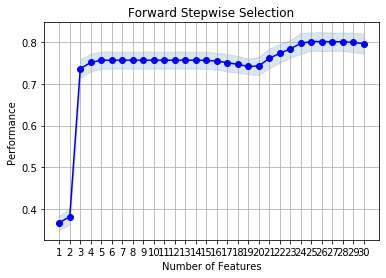

In [320]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fwd_1 = SFS(LogisticRegression(),k_features=(1,30),forward=True,floating=False,scoring = 'f1',cv = 10)
fwd_1.fit(Xn5,yn5)
fwd_1.k_feature_names_

fig1 = plot_sfs(fwd_1.get_metric_dict(), kind='std_dev')
plt.title('Forward Stepwise Selection')
plt.grid()
plt.show()

Forward Stepwise selection suggests using at least 25 features  will keep the performance. Let's identify the feature names

### Backward Stepwise Selection

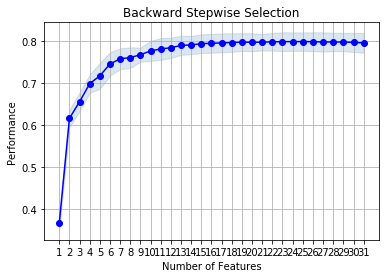

In [319]:
bwd_1 = SFS(LogisticRegression(),k_features=(1,31),forward=False,floating=False,scoring = 'f1',cv = 10)
bwd_1.fit(Xn5,yn5)
bwd_1.k_feature_names_

fig2 = plot_sfs(bwd_1.get_metric_dict(), kind='std_dev')
plt.title('Backward Stepwise Selection')
plt.grid()
plt.show()

### Bi-directional Selection


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

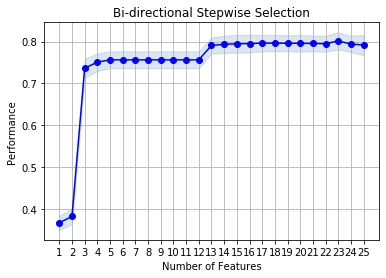

In [321]:
bid_1 = SFS(LogisticRegression(),k_features=(1,31),forward=True,floating=True,scoring = 'f1',cv = 10)
bid_1.fit(Xn5,yn5)
bid_1.k_feature_names_

fig3 = plot_sfs(bid_1.get_metric_dict(), kind='std_dev')
plt.title('Bi-directional Stepwise Selection')
plt.grid()
plt.show()

It is similar to forward selection but the difference is while adding a new feature it also checks the significance of already added features and if it finds any of the already selected features insignificant then it simply removes that particular feature through backward elimination.
As can be seen above, it may not be necessary to chose the 25 features as stated in the previous selection techniques. Recursive elimination seems to have the adequate number best combination of variables and more simple to implement.

## Embedded Method

### Lasso Regularization
The reason we run Lasso regularization is to reduce overfitting and model complexity. 

In [334]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(Xn5, yn5)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(Xn5,yn5))
coef = pd.Series(reg.coef_, index = Xn5.columns)
print("Lasso regreesionpicked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.000057
Best score using built-in LassoCV: 0.426233
Lasso regreesionpicked 28 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

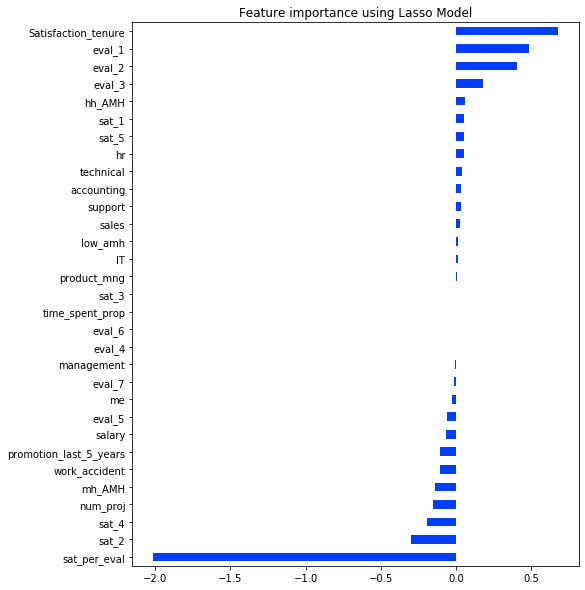

In [335]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

a model wil be run using the features selected by Lasso.

# Model Interpretation

Text(0.5, 1.0, 'F1-SCORE')

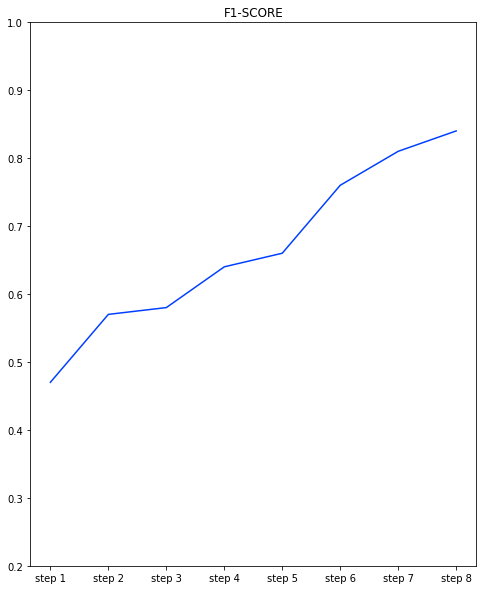

In [357]:
a=np.array([0.47, 0.57, 0.58,0.64,0.66,0.76,0.81,0.84])
b=np.array(['step 1', 'step 2', 'step 3','step 4','step 5','step 6','step 7','step 8'])
plt.plot(b,a)
plt.ylim(0.2,1)
plt.title('F1-SCORE')

As more feature engineering occurred, the f1-score for the test set had a higher level than the final train set which an f1 score of 0,84 and macro average score of 0.92. There is room for improvement if one can bin the features created from interaction between features, or adeqautely implement the Weight of Evidence metric which great for logistic regression 

The final features are 'num_proj', 'work_accident', 'promotion_last_5_years', 'salary',
       'Satisfaction_tenure', 'sat_1', 'sat_2', 'sat_3', 'sat_4', 'sat_5',
       'eval_1', 'eval_2', 'eval_4', 'eval_5', 'eval_6', 'eval_7', 'mh_AMH',
       'sat_per_eval' with coefficients.

# Future Work
Based on the results from project, the following recommendations are made:

- Develop a flexible yet robust pipeline to improve the evaluation and validation of models and manage the feature engineering.
- After the EDA, local outlier detection was to eliminate the outliers. There are various outliers including KMeans, DBScan, basic z-scores and isolation forests. Having researched these techniques especially for case studies concerning churn, these outlier detection techniques have significantly improved the evaluation metric (f1-score).
- Investigate the use of entropy based binning techniques deal with the features (time_spend_company and number of projects)  with discrete variables. According to [Paul Brodersen](https://github.com/paulbrodersen/entropy_based_binning), for discrete, ordinal data neither set of approaches is very desirable. Treating discrete, ordinal data as categorical may result in mappings, in which values that are far apart in the original space are grouped together in one bin. Conversely, ranking can result in many ties, and if one enforces a discrete uniform target distribution, data points with the same rank can end up in different bins, which is generally also undesirable. According to [Saed_Sayaad](https://www.saedsayad.com/supervised_binning.htm), "entropy based method uses a split approach. The entropy (or the information content) is calculated based on the class label. Intuitively, it finds the best split so that the bins are as pure as possible that is the majority of the values in a bin correspond to have the same class label. Formally, it is characterized by finding the split with the maximal information gain."
- Explore the use of probability ratio binning. 
- Review and implement GPLearn and Deep feature Synthesis to create feature and possibly improve the model score. These techniques may improve the evaluation metric but this is trading-off interpretability of the model. Moreover, if the business requires actionable insights, this will not be possible.


In [ ]:
#weight of evidence
# number of projects
turn_df = df.groupby('number_of_projects')['left'].mean()
turn_df = pd.DataFrame(turn_df)
turn_df = turn_df.rename(columns = {'left':'Good'})
turn_df['Bad'] = 1-turn_df.Good
turn_df['Bad'] = np.where(turn_df['Bad'] == 0,0.0000001, turn_df['Bad'])

turn_df['WoE_Proj'] = np.log(turn_df.Good/turn_df.Bad)
turn_df


df.loc[:,'WoE_Encode_Num'] = df['number_of_projects'].map(turn_df['WoE_Proj'])
df
# time spend company
turn_df2 = df.groupby('time_spend_company')['left'].mean()
turn_df2 = pd.DataFrame(turn_df2)
turn_df2 = turn_df2.rename(columns = {'left':'Good'})
turn_df2['Bad'] = 1-turn_df2.Good
turn_df2['Bad'] = np.where(turn_df2['Bad'] == 0,0.0000001, turn_df2['Bad'])

turn_df2['WoE_Time'] = np.log(turn_df2.Good/turn_df2.Bad)
turn_df2

df.loc[:,'WoE_Encode_Time'] = df['time_spend_company'].map(turn_df2['WoE_Time'])
df

# probability ratio encoding
turn_df2 = df.groupby('time_spend_company')['left'].mean()
turn_df2 = pd.DataFrame(turn_df2)
turn_df2 = turn_df2.rename(columns = {'left':'Good'})
turn_df2['Bad'] = 1-turn_df2.Good
turn_df2['Bad'] = np.where(turn_df2['Bad'] == 0,0.0000001, turn_df2['Bad'])


turn_df2['WoE_Time'] = np.log(turn_df2.Good/turn_df2.Bad)
turn_df2

In [1]:
--to hide_code_pdf

SyntaxError: invalid syntax (<ipython-input-1-1c3112456a46>, line 1)

In [2]:
jupyter nbconvert --to hide_code_pdf MarangMutloatse_Individual_Assignment.ipynb

SyntaxError: invalid syntax (<ipython-input-2-d4ba094a8221>, line 1)